In [1]:
import numpy as np
import matplotlib.pyplot as plt #matplob lib
%matplotlib inline
import os

import astropy.io.ascii as at
from scipy.interpolate import griddata, LinearNDInterpolator, interp2d

In [2]:
# read in our MIST isochrone
data = at.read("MIST_iso_67e56fd8ac521.iso.cmd")

# filter out AGB/RGB stars so we're left with just main sequence stars
ms = (data['EEP'] < 605) & (data['log_g'] > 2.0)
data = data[ms]
data[:3]

EEP,isochrone_age_yr,initial_mass,star_mass,log_Teff,log_g,log_L,[Fe/H]_init,[Fe/H],Bessell_U,Bessell_B,Bessell_V,Bessell_R,Bessell_I,2MASS_J,2MASS_H,2MASS_Ks,Kepler_Kp,Kepler_D51,Hipparcos_Hp,Tycho_B,Tycho_V,Gaia_G_DR2Rev,Gaia_BP_DR2Rev,Gaia_RP_DR2Rev,Gaia_G_MAW,Gaia_BP_MAWb,Gaia_BP_MAWf,Gaia_RP_MAW,TESS,Gaia_G_EDR3,Gaia_BP_EDR3,Gaia_RP_EDR3,phase
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
211,2500000000.0000005,0.10331965605076723,0.10331935726529833,3.455287273155895,5.219173330672141,-2.9935423338842977,0.05,0.10795,19.470888,18.148815,16.410881,14.574785,12.504429,10.316504,9.585037,9.323067,14.261245,17.276842,15.961245,18.40288,16.695791,14.084206,16.665436,12.764818,14.118049,16.617462,16.660431,12.73735,12.571995,14.136039,16.642942,12.737313,0.0
212,2500000000.0000005,0.10722995675658707,0.10722964163649101,3.4580977453510204,5.210097400095176,-2.95945314032489,0.05,0.107969,19.265442,17.957069,16.2365,14.435621,12.388101,10.238168,9.511384,9.250607,14.135765,17.09045,15.810016,18.209255,16.519737,13.966937,16.490999,12.653538,13.998289,16.443157,16.486118,12.626325,12.465951,14.016408,16.468479,12.625916,0.0
220,2500000000.0000005,0.14551443880232373,0.14551392990520892,3.483337669343613,5.125557731436499,-2.643791764800995,0.05,0.108199,17.500029,16.293571,14.681582,13.181349,11.3621,9.52002,8.81824,8.567975,13.008567,15.460226,14.449681,16.541615,14.946157,12.906281,14.944551,11.654606,12.918333,14.897621,14.940943,11.629437,11.509311,12.937285,14.921345,11.627034,0.0


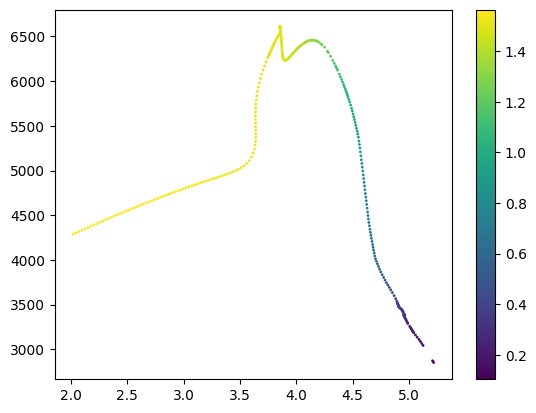

In [6]:
# data['initial_mass']
plt.figure()
plt.scatter(data['log_g'], 10**data['log_Teff'], c=data['initial_mass'], s=1)
# plt.xlim(3.8,3.9)
plt.colorbar()
data['log_g'][(data['log_g'] > 3.8) & (data['log_g'] < 3.9)]
plt.show()

# **Interpolation using scipy.interpolate.griddata**

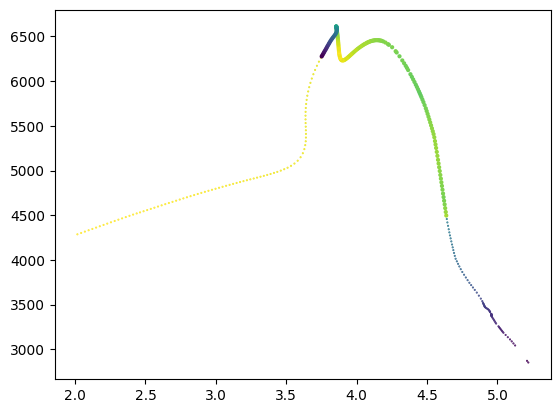

In [7]:
x_new = (np.arange(2.0,5.5,3.5/len(data)),
         np.arange(3000.0,6500.0,3500.0/len(data)), 
         )
# np.shape(points), np.shape(data['initial_mass'])
grid_z1 = griddata(points=(data['log_g'], 10**data['log_Teff']), values=data['initial_mass'], xi=x_new, method='linear')
fig, ax = plt.subplots()
ax.scatter(data['log_g'], 10**data['log_Teff'], c=data['initial_mass'], marker='.', s=1)
ax.scatter(data['log_g'], 10**data['log_Teff'], c=grid_z1, marker='o', s=4)
grid_z1

# ax.set_xlim(3.85,3.865)
plt.show()

# **Interpolation using scipy.interpolate.LinearNDInterpolator**

In [33]:
interp = LinearNDInterpolator(list(zip(data['log_g'], 10**data['log_Teff'])), data['initial_mass'])
interp(2.53,4500)

array(1.51124555)

In [39]:
x_new = np.arange(2.0,5.5,3.5/len(data))
y_new = np.arange(3000.0,6500.0,3500.0/len(data))

mass_interp = interp(x_new, y_new)
mass_interp

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

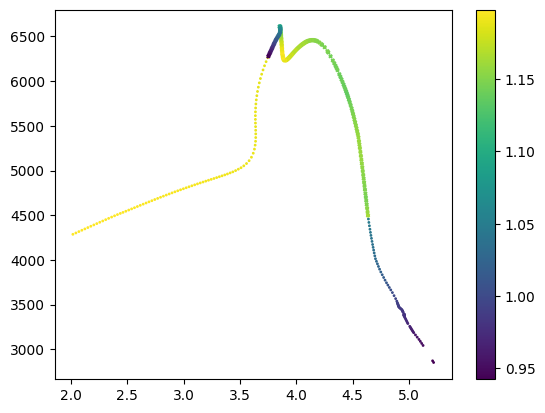

In [40]:
plt.scatter(data['log_g'], 10**data['log_Teff'], c=data['initial_mass'], s=1, label="input point")
plt.scatter(data['log_g'], 10**data['log_Teff'], c=mass_interp, s=5, marker='x', label='interp')
# plt.legend()
plt.colorbar()
# plt.axis("equal")
plt.show()

# **Comparison of griddata vs. NDInterp**

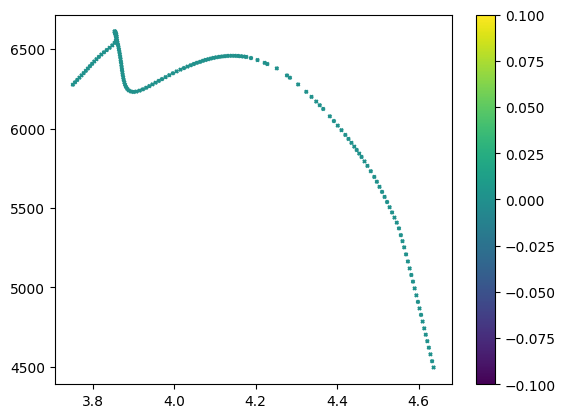

In [45]:
plt.figure()
plt.scatter(data['log_g'], 10**data['log_Teff'], c=mass_interp-grid_z1, s=5, marker='x', label='interp')
# plt.scatter(data['log_g'], 10**data['log_Teff'], c=grid_z1, marker='o', s=5)
plt.colorbar()

# **Interpolation using scipy.interpolate.RegularGridInterpolator**

In [8]:
# RegularGridInterpolator

# we have 2D data (x,y) = (log_g, Teff) and we want to interpolate f(x,y) (mass)
# store (x,y) pairs using np.meshgrid
xg, yg = np.meshgrid(data['log_g'], 10**data['log_Teff'], indexing='ij')

In [240]:
all(data['log_g'][i] <= data['log_g'][i+1] for i in range(len(data['log_g']) - 1))

False

In [239]:
# define the interpolation function
xy_new = (np.arange(2.0,5.5,3.5/len(data)), np.arange(3000.0,6500.0,3500.0/len(data)))
interp = RegularGridInterpolator((xg, yg), data['initial_mass'])
interp

ValueError: The points in dimension 0 must be strictly ascending or descending

# **Various demos and testing**

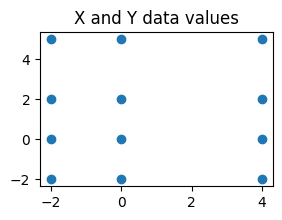

In [267]:
# RegularGridInterpolator

# suppose we have 2D data and we want to interpolate the function ff(x, y)
x, y = np.array([-2, 0, 4]), np.array([-2, 0, 2, 5])
def ff(x, y):
    return x**2 + y**2

# define some x,y values and pair them together using np.meshgrid
xg, yg = np.meshgrid(x, y, indexing='ij')
plt.figure(figsize=(3,2))
plt.scatter(xg, yg)
plt.title("X and Y data values")
plt.show()

AttributeError: 'Table' object has no attribute 'ravel'

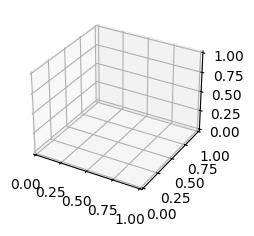

In [268]:
# run the x and y values that we have through our function to get our data that we want to interpolate
fig = plt.figure(figsize=(5,2.5))
ax = fig.add_subplot(projection='3d')
ax.scatter(xg.ravel(), yg.ravel(), data.ravel())
plt.show()

In [197]:
# define the interpolation function
interp = RegularGridInterpolator((x, y), data,
                                 bounds_error=False, fill_value=None)
interp

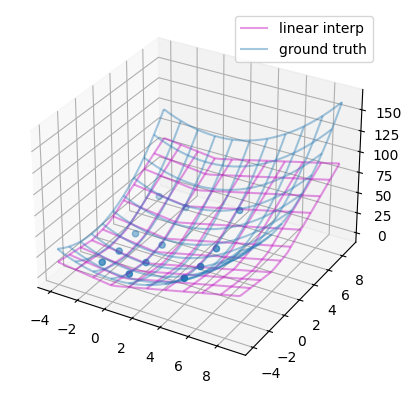

In [222]:
# xx and yy are the new values we want to evaluate ff at
xx = np.linspace(-4, 9, 31)
yy = np.linspace(-4, 9, 31)

# put xx and yy into a meshgrid
X, Y = np.meshgrid(xx, yy, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plot the data
ax.scatter(xg.ravel(), yg.ravel(), data.ravel())

# plot the result from the interpolator
ax.plot_wireframe(X, Y, interp((X, Y)), rstride=3, cstride=3,
                  alpha=0.4, color='m', label='linear interp')

# ground truth <-- I won't have this since I don't have a functional form for mass(log_g, temp)
ax.plot_wireframe(X, Y, ff(X, Y), rstride=3, cstride=3,
                  alpha=0.4, label='ground truth')
plt.legend()
plt.show

In [171]:
# griddata
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

In [149]:
rng = np.random.default_rng()
points = rng.random((1000, 2))
values = func(points[:,0], points[:,1])

In [150]:
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

In [170]:
# misc
# points = (10**data['log_Teff'], data['log_g'])
# np.shape(points), np.shape(data['initial_mass'])
# grid_z1 = griddata(points, data['initial_mass'], (10**data['log_Teff'], data['log_g']), method='linear')